In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np
import pandas as pd

from util import engineer_features, prep_X_y

DATA_DIR = Path("./pistachio_1_data")
dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")

sorted_dyads_df = dyads_df.sort_values(
    by="ActivityDateTime", key=lambda x: pd.to_datetime(x)
)
cleaned_dyads_dfs = engineer_features(sorted_dyads_df)

/var/folders/gv/lj5cf4w14fqc6937ndlg7qb40000gr/T/ipykernel_28283/6524477.py:12: DtypeWarning: Columns (95,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")
/Users/zhu.henian/projects/pistachio/util.py:150: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])


In [2]:
from hr_model import HrModel
from modeling import (
    TuningMethod,
    eval_model_on_feature_sets,
    retrain_and_predict,
    supersets_to_test,
)

In [15]:
import os

# Params
weeks = (0, 20)
active_hours = (7, 20)
tuning_method: TuningMethod = "balanced_accuracy"
# estimator = "xgboost"
estimator = "lrl2"
random_state = 42
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

In [16]:
no_retrain_results = eval_model_on_feature_sets(
    supersets_to_test=supersets_to_test,
    dfs=cleaned_dyads_dfs,
    weeks=weeks,
    active_hours=active_hours,
    estimator=estimator,
    mode="no_retrain",
    tuning_method=tuning_method,
    random_state=random_state,
    verbose=True,
)

Feature sets: watch
{'C': np.float64(0.032677340116630725)}


  0%|          | 0/21 [00:00<?, ?it/s]

Week 0 AUROC: 0.5816881652771224 sensitivity: 0.5384615384615384, specificity: 0.5412065439672802
Week 1 AUROC: 0.4633426686867759 sensitivity: 0.4106280193236715, specificity: 0.5376979936642028
Week 2 AUROC: 0.4954743849905656 sensitivity: 0.4666666666666667, specificity: 0.514151447185731
Week 3 AUROC: 0.6067868794579052 sensitivity: 0.6014492753623188, specificity: 0.5441555399390958
Week 4 AUROC: 0.5754694612396368 sensitivity: 0.5287356321839081, specificity: 0.5624850083952986
Week 5 AUROC: 0.47553617659081615 sensitivity: 0.4634146341463415, specificity: 0.4987709497206704
Week 6 AUROC: 0.555860918972332 sensitivity: 0.55, specificity: 0.5269268774703557
Week 7 AUROC: 0.5974434786738863 sensitivity: 0.5181818181818182, specificity: 0.6199059561128527
Week 8 AUROC: 0.6569056909372009 sensitivity: 0.6063829787234043, specificity: 0.6347009391992091
Week 9 AUROC: 0.4923313311265668 sensitivity: 0.4107142857142857, specificity: 0.5770632647747982
Week 10 AUROC: 0.5249649593407523 s

  0%|          | 0/21 [00:00<?, ?it/s]

Week 0 AUROC: 0.5818834880184574 sensitivity: 0.5384615384615384, specificity: 0.5456032719836401
Week 1 AUROC: 0.46489652041279605 sensitivity: 0.4106280193236715, specificity: 0.5381203801478353
Week 2 AUROC: 0.49631670760796043 sensitivity: 0.4666666666666667, specificity: 0.5189575990601303
Week 3 AUROC: 0.606904851626658 sensitivity: 0.5869565217391305, specificity: 0.5476692433825252
Week 4 AUROC: 0.5734678235360612 sensitivity: 0.5287356321839081, specificity: 0.5704005756776205
Week 5 AUROC: 0.47298950810737156 sensitivity: 0.45121951219512196, specificity: 0.5045810055865921
Week 6 AUROC: 0.558973567193676 sensitivity: 0.525, specificity: 0.5329792490118577
Week 7 AUROC: 0.5960530065545739 sensitivity: 0.4909090909090909, specificity: 0.6255224660397074
Week 8 AUROC: 0.6555489529979701 sensitivity: 0.6063829787234043, specificity: 0.6371725160652496
Week 9 AUROC: 0.49188269423885156 sensitivity: 0.4017857142857143, specificity: 0.5808383233532934
Week 10 AUROC: 0.5258787351530

  0%|          | 0/21 [00:00<?, ?it/s]

Week 0 AUROC: 0.609119430898572 sensitivity: 0.6495726495726496, specificity: 0.49366053169734153
Week 1 AUROC: 0.4875487810477021 sensitivity: 0.463768115942029, specificity: 0.5295670538542767
Week 2 AUROC: 0.5156652070205419 sensitivity: 0.5, specificity: 0.5548435330556446
Week 3 AUROC: 0.6330335652038119 sensitivity: 0.6159420289855072, specificity: 0.6036542515811666
Week 4 AUROC: 0.5908635991431006 sensitivity: 0.5057471264367817, specificity: 0.6396018229791317
Week 5 AUROC: 0.5033901076440932 sensitivity: 0.36585365853658536, specificity: 0.6098324022346369
Week 6 AUROC: 0.6056293231225296 sensitivity: 0.5, specificity: 0.626852766798419
Week 7 AUROC: 0.6065806972546783 sensitivity: 0.2818181818181818, specificity: 0.7496081504702194
Week 8 AUROC: 0.6403224619009056 sensitivity: 0.3617021276595745, specificity: 0.7796589223924864
Week 9 AUROC: 0.4751994458288392 sensitivity: 0.25892857142857145, specificity: 0.7241603749023692
Week 10 AUROC: 0.5283950169765952 sensitivity: 0.3

  0%|          | 0/21 [00:00<?, ?it/s]

Week 0 AUROC: 0.6102166465663398 sensitivity: 0.6794871794871795, specificity: 0.4780163599182004
Week 1 AUROC: 0.4956623764851119 sensitivity: 0.4975845410628019, specificity: 0.5125659978880676
Week 2 AUROC: 0.5234547331695681 sensitivity: 0.49333333333333335, specificity: 0.5649898536793763
Week 3 AUROC: 0.6447586408248207 sensitivity: 0.6086956521739131, specificity: 0.6220426329351136
Week 4 AUROC: 0.5911103575101392 sensitivity: 0.47126436781609193, specificity: 0.6665867114415928
Week 5 AUROC: 0.4983335604305764 sensitivity: 0.2926829268292683, specificity: 0.6379888268156425
Week 6 AUROC: 0.6099987648221343 sensitivity: 0.475, specificity: 0.6561264822134387
Week 7 AUROC: 0.6111439631423958 sensitivity: 0.2727272727272727, specificity: 0.7804336468129571
Week 8 AUROC: 0.6263396472481358 sensitivity: 0.2765957446808511, specificity: 0.7931290163124073
Week 9 AUROC: 0.4735804013091829 sensitivity: 0.26785714285714285, specificity: 0.7613902629523561
Week 10 AUROC: 0.5383785841157

In [17]:
import warnings

warnings.filterwarnings("ignore")

test_case = [
    ["watch"],
    ["watch", "demographic"],
    ["watch", "medical"],
    ["watch", "demographic", "medical"],
]

retrain_dyad_results = eval_model_on_feature_sets(
    supersets_to_test=test_case,
    dfs=cleaned_dyads_dfs,
    weeks=weeks,
    active_hours=active_hours,
    estimator=estimator,
    mode="retrain_dyad",
    tuning_method=tuning_method,
    random_state=random_state,
    verbose=False,
)

Feature sets: watch
{'C': np.float64(0.032677340116630725)}


  0%|          | 0/21 [00:00<?, ?it/s]

Week 0 AUROC: 0.5816881652771224 sensitivity: 0.5384615384615384, specificity: 0.5412065439672802


  0%|          | 0/28 [00:00<?, ?it/s]

Week 1 AUROC: 0.5838748348458647 sensitivity: 0.6811594202898551, specificity: 0.5501583949313622


  0%|          | 0/28 [00:00<?, ?it/s]

Week 2 AUROC: 0.5597507921250312 sensitivity: 0.4, specificity: 0.6701911780412261


  0%|          | 0/28 [00:00<?, ?it/s]

Week 3 AUROC: 0.7125756634449232 sensitivity: 0.5, specificity: 0.7013352073085032


  0%|          | 0/28 [00:00<?, ?it/s]

Week 4 AUROC: 0.6815521239140563 sensitivity: 0.5517241379310345, specificity: 0.6314463900215879


  0%|          | 0/28 [00:00<?, ?it/s]

Week 5 AUROC: 0.6799563973293363 sensitivity: 0.4634146341463415, specificity: 0.7359776536312849


  0%|          | 0/28 [00:00<?, ?it/s]

Week 6 AUROC: 0.7629786314229249 sensitivity: 0.625, specificity: 0.8233695652173914


  0%|          | 0/28 [00:00<?, ?it/s]

Week 7 AUROC: 0.655741189322694 sensitivity: 0.21818181818181817, specificity: 0.8565830721003135


  0%|          | 0/28 [00:00<?, ?it/s]

Week 8 AUROC: 0.6687916092594736 sensitivity: 0.6276595744680851, specificity: 0.7030400395452299


  0%|          | 0/28 [00:00<?, ?it/s]

Week 9 AUROC: 0.6840062111801243 sensitivity: 0.6071428571428571, specificity: 0.7416037490236917


  0%|          | 0/28 [00:00<?, ?it/s]

Week 10 AUROC: 0.7814293568226581 sensitivity: 0.5238095238095238, specificity: 0.794214666328343


  0%|          | 0/28 [00:00<?, ?it/s]

Week 11 AUROC: 0.7757300345030715 sensitivity: 0.4444444444444444, specificity: 0.8573592527139611


  0%|          | 0/28 [00:00<?, ?it/s]

Week 12 AUROC: 0.7584788836521579 sensitivity: 0.6212121212121212, specificity: 0.8042694760188522


  0%|          | 0/28 [00:00<?, ?it/s]

Week 13 AUROC: 0.7628396572827418 sensitivity: 0.4418604651162791, specificity: 0.7088259109311741


  0%|          | 0/28 [00:00<?, ?it/s]

Week 14 AUROC: 0.8132031056950748 sensitivity: 0.5294117647058824, specificity: 0.7495025425602476


  0%|          | 0/28 [00:00<?, ?it/s]

Week 15 AUROC: 0.9105191605064152 sensitivity: 0.7333333333333333, specificity: 0.8072903390262555


  0%|          | 0/28 [00:00<?, ?it/s]

Week 16 AUROC: 0.8122597280825129 sensitivity: 0.06666666666666667, specificity: 0.8867791842475387


  0%|          | 0/28 [00:00<?, ?it/s]

Week 17 AUROC: 0.868090986394558 sensitivity: 1.0, specificity: 0.6454081632653061


  0%|          | 0/28 [00:00<?, ?it/s]

Week 18 AUROC: 0.8169370382267909 sensitivity: 0.4090909090909091, specificity: 0.7566254416961131


  0%|          | 0/28 [00:00<?, ?it/s]

Week 19 AUROC: 0.7637960516088916 sensitivity: 0.2857142857142857, specificity: 0.7986942328618063


  0%|          | 0/28 [00:00<?, ?it/s]

Week 20 AUROC: 0.9066828254847645 sensitivity: 1.0, specificity: 0.7721606648199446
Feature sets: watch_demographic
{'C': np.float64(0.03126688166722343)}


  0%|          | 0/21 [00:00<?, ?it/s]

Week 0 AUROC: 0.5818834880184574 sensitivity: 0.5384615384615384, specificity: 0.5456032719836401


  0%|          | 0/28 [00:00<?, ?it/s]

Week 1 AUROC: 0.5886496385738844 sensitivity: 0.6811594202898551, specificity: 0.550791974656811


  0%|          | 0/28 [00:00<?, ?it/s]

Week 2 AUROC: 0.5666545622841682 sensitivity: 0.46, specificity: 0.6538502616682688


  0%|          | 0/28 [00:00<?, ?it/s]

Week 3 AUROC: 0.7240096278869232 sensitivity: 0.5144927536231884, specificity: 0.6986413680018739


  0%|          | 0/28 [00:00<?, ?it/s]

Week 4 AUROC: 0.6763398703622523 sensitivity: 0.5747126436781609, specificity: 0.6037419045334612


  0%|          | 0/28 [00:00<?, ?it/s]

Week 5 AUROC: 0.6710083117590953 sensitivity: 0.4634146341463415, specificity: 0.7356424581005586


  0%|          | 0/28 [00:00<?, ?it/s]

Week 6 AUROC: 0.770908473320158 sensitivity: 0.6, specificity: 0.8237401185770751


  0%|          | 0/28 [00:00<?, ?it/s]

Week 7 AUROC: 0.6707846489978151 sensitivity: 0.16363636363636364, specificity: 0.8547544409613375


  0%|          | 0/28 [00:00<?, ?it/s]

Week 8 AUROC: 0.6715576718797658 sensitivity: 0.5957446808510638, specificity: 0.708601087493821


  0%|          | 0/28 [00:00<?, ?it/s]

Week 9 AUROC: 0.6848558318146316 sensitivity: 0.5714285714285714, specificity: 0.7422546211923978


  0%|          | 0/28 [00:00<?, ?it/s]

Week 10 AUROC: 0.7739092084435906 sensitivity: 0.5952380952380952, specificity: 0.7940877949758944


  0%|          | 0/28 [00:00<?, ?it/s]

Week 11 AUROC: 0.7774043451429212 sensitivity: 0.4305555555555556, specificity: 0.845746023731381


  0%|          | 0/28 [00:00<?, ?it/s]

Week 12 AUROC: 0.758600700657812 sensitivity: 0.42424242424242425, specificity: 0.8379539783753812


  0%|          | 0/28 [00:00<?, ?it/s]

Week 13 AUROC: 0.760094153092929 sensitivity: 0.46511627906976744, specificity: 0.7007287449392713


  0%|          | 0/28 [00:00<?, ?it/s]

Week 14 AUROC: 0.8158041903473748 sensitivity: 0.5294117647058824, specificity: 0.7700641167366792


  0%|          | 0/28 [00:00<?, ?it/s]

Week 15 AUROC: 0.9105531481009431 sensitivity: 0.7666666666666667, specificity: 0.811368850369615


  0%|          | 0/28 [00:00<?, ?it/s]

Week 16 AUROC: 0.8003750586029066 sensitivity: 0.0, specificity: 0.890295358649789


  0%|          | 0/28 [00:00<?, ?it/s]

Week 17 AUROC: 0.8745748299319729 sensitivity: 1.0, specificity: 0.6823979591836735


  0%|          | 0/28 [00:00<?, ?it/s]

Week 18 AUROC: 0.8130822357854159 sensitivity: 0.13636363636363635, specificity: 0.8736749116607774


  0%|          | 0/28 [00:00<?, ?it/s]

Week 19 AUROC: 0.7653505362972175 sensitivity: 0.2857142857142857, specificity: 0.7834602829162133


  0%|          | 0/28 [00:00<?, ?it/s]

Week 20 AUROC: 0.909972299168975 sensitivity: 1.0, specificity: 0.7714681440443213
Feature sets: watch_medical
{'C': np.float64(0.8151379205336398)}


  0%|          | 0/21 [00:00<?, ?it/s]

Week 0 AUROC: 0.609119430898572 sensitivity: 0.6495726495726496, specificity: 0.49366053169734153


  0%|          | 0/28 [00:00<?, ?it/s]

Week 1 AUROC: 0.6091522172739747 sensitivity: 0.6859903381642513, specificity: 0.5597676874340021


  0%|          | 0/28 [00:00<?, ?it/s]

Week 2 AUROC: 0.5665541671116807 sensitivity: 0.38, specificity: 0.683007583039624


  0%|          | 0/28 [00:00<?, ?it/s]

Week 3 AUROC: 0.6952235699905962 sensitivity: 0.5072463768115942, specificity: 0.7132817990161631


  0%|          | 0/28 [00:00<?, ?it/s]

Week 4 AUROC: 0.6941795353222886 sensitivity: 0.6666666666666666, specificity: 0.5742384264811705


  0%|          | 0/28 [00:00<?, ?it/s]

Week 5 AUROC: 0.6876400054503339 sensitivity: 0.45121951219512196, specificity: 0.7731843575418994


  0%|          | 0/28 [00:00<?, ?it/s]

Week 6 AUROC: 0.7406558794466402 sensitivity: 0.6, specificity: 0.8344861660079052


  0%|          | 0/28 [00:00<?, ?it/s]

Week 7 AUROC: 0.6883525695829771 sensitivity: 0.2727272727272727, specificity: 0.8612852664576802


  0%|          | 0/28 [00:00<?, ?it/s]

Week 8 AUROC: 0.6258624225660226 sensitivity: 0.6170212765957447, specificity: 0.7168808699950568


  0%|          | 0/28 [00:00<?, ?it/s]

Week 9 AUROC: 0.6946189143452226 sensitivity: 0.5267857142857143, specificity: 0.7701119500130175


  0%|          | 0/28 [00:00<?, ?it/s]

Week 10 AUROC: 0.7745209096071822 sensitivity: 0.4523809523809524, specificity: 0.8110885562040091


  0%|          | 0/28 [00:00<?, ?it/s]

Week 11 AUROC: 0.8222951555443351 sensitivity: 0.5138888888888888, specificity: 0.8520575612219137


  0%|          | 0/28 [00:00<?, ?it/s]

Week 12 AUROC: 0.7685497895506214 sensitivity: 0.6212121212121212, specificity: 0.8106459661768783


  0%|          | 0/28 [00:00<?, ?it/s]

Week 13 AUROC: 0.8045155823368798 sensitivity: 0.5813953488372093, specificity: 0.6730364372469636


  0%|          | 0/28 [00:00<?, ?it/s]

Week 14 AUROC: 0.8243487534301804 sensitivity: 0.5882352941176471, specificity: 0.7596727835507406


  0%|          | 0/28 [00:00<?, ?it/s]

Week 15 AUROC: 0.9107655705667432 sensitivity: 0.7, specificity: 0.7787407596227377


  0%|          | 0/28 [00:00<?, ?it/s]

Week 16 AUROC: 0.8243553680262542 sensitivity: 0.2, specificity: 0.8980309423347398


  0%|          | 0/28 [00:00<?, ?it/s]

Week 17 AUROC: 0.8624574829931972 sensitivity: 1.0, specificity: 0.7210884353741497


  0%|          | 0/28 [00:00<?, ?it/s]

Week 18 AUROC: 0.7974622550594282 sensitivity: 0.0, specificity: 0.9059187279151943


  0%|          | 0/28 [00:00<?, ?it/s]

Week 19 AUROC: 0.8373231773667029 sensitivity: 0.2857142857142857, specificity: 0.8264417845484222


  0%|          | 0/28 [00:00<?, ?it/s]

Week 20 AUROC: 0.9047783933518005 sensitivity: 1.0, specificity: 0.7707756232686981
Feature sets: watch_demographic_medical
{'C': np.float64(561.1629779962702)}


  0%|          | 0/21 [00:00<?, ?it/s]

Week 0 AUROC: 0.6102166465663398 sensitivity: 0.6794871794871795, specificity: 0.4780163599182004


  0%|          | 0/28 [00:00<?, ?it/s]

Week 1 AUROC: 0.5954970948176035 sensitivity: 0.7294685990338164, specificity: 0.5336853220696938


  0%|          | 0/28 [00:00<?, ?it/s]

Week 2 AUROC: 0.6876784506390402 sensitivity: 0.38, specificity: 0.6539570650432553


  0%|          | 0/28 [00:00<?, ?it/s]

Week 3 AUROC: 0.7156293603022803 sensitivity: 0.5, specificity: 0.711759194190677


  0%|          | 0/28 [00:00<?, ?it/s]

Week 4 AUROC: 0.7120343642043215 sensitivity: 0.6551724137931034, specificity: 0.6297673302950347


  0%|          | 0/28 [00:00<?, ?it/s]

Week 5 AUROC: 0.670489167461507 sensitivity: 0.47560975609756095, specificity: 0.775754189944134


  0%|          | 0/28 [00:00<?, ?it/s]

Week 6 AUROC: 0.7831923171936759 sensitivity: 0.625, specificity: 0.8354743083003953


  0%|          | 0/28 [00:00<?, ?it/s]

Week 7 AUROC: 0.6523997815142016 sensitivity: 0.2636363636363636, specificity: 0.8601097178683386


  0%|          | 0/28 [00:00<?, ?it/s]

Week 8 AUROC: 0.6516838274734176 sensitivity: 0.6382978723404256, specificity: 0.7245427582797825


  0%|          | 0/28 [00:00<?, ?it/s]

Week 9 AUROC: 0.6852056756053111 sensitivity: 0.625, specificity: 0.7323613642280656


  0%|          | 0/28 [00:00<?, ?it/s]

Week 10 AUROC: 0.8022528727299091 sensitivity: 0.5238095238095238, specificity: 0.8206039076376554


  0%|          | 0/28 [00:00<?, ?it/s]

Week 11 AUROC: 0.8001363993379899 sensitivity: 0.5138888888888888, specificity: 0.8430951779853573


  0%|          | 0/28 [00:00<?, ?it/s]

Week 12 AUROC: 0.7703644428762255 sensitivity: 0.5606060606060606, specificity: 0.8124480177432769


  0%|          | 0/28 [00:00<?, ?it/s]

Week 13 AUROC: 0.7894134262310518 sensitivity: 0.46511627906976744, specificity: 0.7280971659919029


  0%|          | 0/28 [00:00<?, ?it/s]

Week 14 AUROC: 0.8308384596376689 sensitivity: 0.6470588235294118, specificity: 0.7797921733362813


  0%|          | 0/28 [00:00<?, ?it/s]

Week 15 AUROC: 0.911661993372419 sensitivity: 0.75, specificity: 0.7828192709660974


  0%|          | 0/28 [00:00<?, ?it/s]

Week 16 AUROC: 0.7557899671823722 sensitivity: 0.13333333333333333, specificity: 0.9289732770745429


  0%|          | 0/28 [00:00<?, ?it/s]

Week 17 AUROC: 0.8958333333333333 sensitivity: 1.0, specificity: 0.7529761904761905


  0%|          | 0/28 [00:00<?, ?it/s]

Week 18 AUROC: 0.8123996145197558 sensitivity: 0.0, specificity: 0.9346289752650176


  0%|          | 0/28 [00:00<?, ?it/s]

Week 19 AUROC: 0.7757655837090005 sensitivity: 0.2857142857142857, specificity: 0.7878128400435256


  0%|          | 0/28 [00:00<?, ?it/s]

Week 20 AUROC: 0.9200138504155124 sensitivity: 1.0, specificity: 0.7721606648199446


# Analysis


In [20]:
import pickle
from pathlib import Path

tuning_method: TuningMethod = "balanced_accuracy"
# tuning_method: TuningMethod = "ref_specificity"

models = ["lrl2", "xgboost"]

feature_sets = [
    "watch",
    "watch_demographic",
    "watch_medical",
    "watch_demographic_medical",
]
data_dir = Path("./intermediate_data")
no_retrain_results = {
    model: {
        k: pickle.load(
            open(data_dir / f"{model}_{tuning_method}_no_retrain_{k}_results.pkl", "rb")
        )
        for k in feature_sets
    }
    for model in models
}
retrain_dyad_results = {
    model: {
        k: pickle.load(
            open(
                data_dir / f"{model}_{tuning_method}_retrain_dyad_{k}_results.pkl", "rb"
            )
        )
        for k in feature_sets
    }
    for model in models
}

full_df = pd.concat(list(cleaned_dyads_dfs.values()), axis=1)
full_df = full_df[full_df["therapy_week"].between(weeks[0], weeks[1])]
full_df = full_df[
    (full_df["ActivityDateTime"].dt.hour.between(active_hours[0], active_hours[1]))
]
full_df_train = full_df[full_df["Arm_Sham"]]
full_df_test = full_df[~full_df["Arm_Sham"]]

X_train, y_train = prep_X_y(full_df_train, "tantrum_within_60m")

hr_model_results, _ = retrain_and_predict(
    HrModel(),
    full_df_train,
    full_df_test,
    mode="no_retrain",
    tuning_method=tuning_method,
)


  0%|          | 0/21 [00:00<?, ?it/s]

Week 0 AUROC: 0.4867259189345079 sensitivity: 0.36752136752136755, specificity: 0.6059304703476482
Week 1 AUROC: 0.5941054639874712 sensitivity: 0.5700483091787439, specificity: 0.6181626187961985
Week 2 AUROC: 0.5149065470468868 sensitivity: 0.44666666666666666, specificity: 0.5831464274271067
Week 3 AUROC: 0.5891716826056402 sensitivity: 0.572463768115942, specificity: 0.6058795970953385
Week 4 AUROC: 0.5212308693338628 sensitivity: 0.42528735632183906, specificity: 0.6171743823458863
Week 5 AUROC: 0.5199591224962529 sensitivity: 0.43902439024390244, specificity: 0.6008938547486034
Week 6 AUROC: 0.46044960474308305 sensitivity: 0.35, specificity: 0.570899209486166
Week 7 AUROC: 0.6026253918495298 sensitivity: 0.6272727272727273, specificity: 0.5779780564263323
Week 8 AUROC: 0.5611820447828695 sensitivity: 0.5212765957446809, specificity: 0.6010874938210579
Week 9 AUROC: 0.5501287797076654 sensitivity: 0.5178571428571429, specificity: 0.582400416558188
Week 10 AUROC: 0.559248921593504

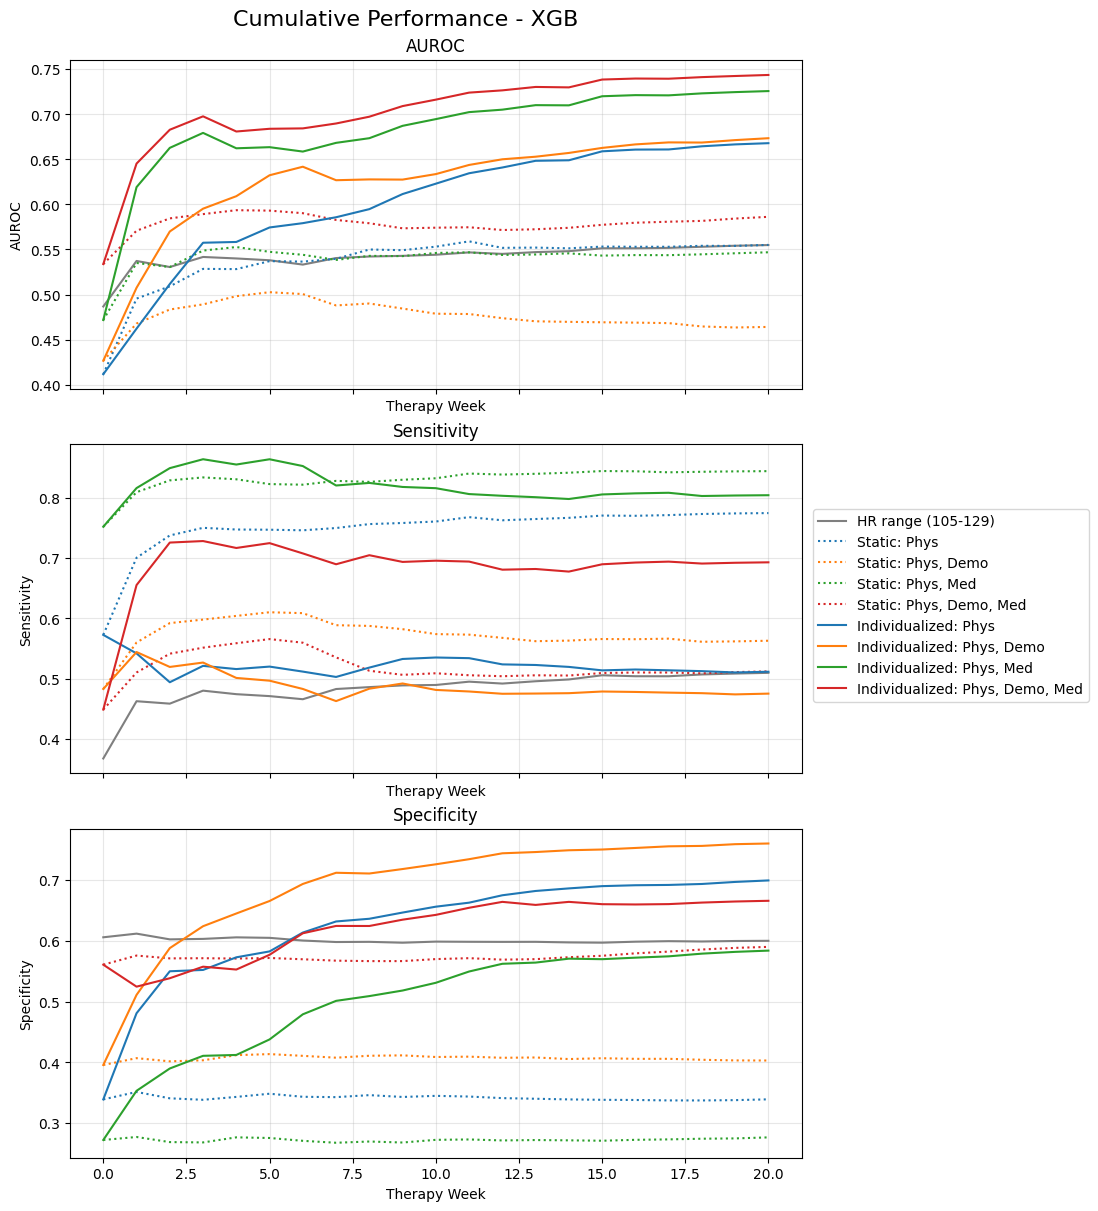

Week 0                    \
                                       Sensitivity Specificity AUROC   
Model                Feature Set                                       
HR range (reference) HR moving average        0.37        0.61  0.49   
Static LR            Phys                     0.54        0.54  0.58   
                     Phys, Demo               0.54        0.55  0.58   
                     Phys, Med                0.65        0.49  0.61   
                     Phys, Demo, Med          0.68        0.48  0.61   
Individualized LR    Phys                     0.54        0.54  0.58   
                     Phys, Demo               0.54        0.55  0.58   
                     Phys, Med                0.65        0.49  0.61   
                     Phys, Demo, Med          0.68        0.48  0.61   
Static XGB           Phys                     0.57        0.34  0.41   
                     Phys, Demo               0.48        0.40  0.43   
                     Phys, Med                0.75        0.27  0.47   
                     Phys, Demo, Med          0.45        0.56  0.53   
Individualized XGB   Phys                     0.57        0.34  0.41   
                     Phys, Demo               0.48        0.40  0.43   
                     Phys, Med                0.75        0.27  0.47   
                     Phys, Demo, Med          0.45        0.56  0.53   

                                           Week 20                    
                                       Sensitivity Specificity AUROC  
Model                Feature Set                                      
HR range (reference) HR moving average        0.51        0.60  0.55  
Static LR            Phys                     0.50        0.56  0.54  
                     Phys, Demo               0.50        0.56  0.54  
                     Phys, Med                0.42        0.69  0.58  
                     Phys, Demo, Med          0.41        0.71  0.59  
Individualized LR    Phys                     0.53        0.72  0.67  
                     Phys, Demo               0.52        0.73  0.67  
                     Phys, Med                0.54        0.73  0.70  
                     Phys, Demo, Med          0.56        0.73  0.71  
Static XGB           Phys                     0.77        0.34  0.56  
                     Phys, Demo               0.56        0.40  0.46  
                     Phys, Med                0.84        0.28  0.55  
                     Phys, Demo, Med          0.51        0.59  0.59  
Individualized XGB   Phys                     0.51        0.70  0.67  
                     Phys, Demo               0.48        0.76  0.67  
                     Phys, Med                0.80        0.58  0.73  
                     Phys, Demo, Med          0.69        0.67  0.74

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import recall_score, roc_auc_score

from modeling import specificity_score

model_friendly_names = {
    "lrl2": "LR",
    "xgboost": "XGB",
}
weeks = (0, 20)


def get_final_metrics(weeks: tuple[int, ...]):
    def get_final_metric(results, metric_fn):
        all_y_pred_proba = np.empty((0, 2))
        all_y_pred = np.array([])
        all_y_true = np.array([])
        for _, y_pred_proba, y_pred, y_true, _ in results:
            all_y_pred_proba = np.concatenate([all_y_pred_proba, y_pred_proba])
            all_y_pred = np.concatenate([all_y_pred, y_pred])
            all_y_true = np.concatenate([all_y_true, y_true])
        if metric_fn is roc_auc_score:
            return metric_fn(all_y_true, all_y_pred_proba[:, 1])
        else:
            return metric_fn(all_y_true, all_y_pred)

    def results_for_model(model: str):
        name = model_friendly_names[model]
        return [
            (f"Static {name}", "Phys", no_retrain_results[model]["watch"]),
            (
                f"Static {name}",
                "Phys, Demo",
                no_retrain_results[model]["watch_demographic"],
            ),
            (
                f"Static {name}",
                "Phys, Med",
                no_retrain_results[model]["watch_medical"],
            ),
            (
                f"Static {name}",
                "Phys, Demo, Med",
                no_retrain_results[model]["watch_demographic_medical"],
            ),
            (
                f"Individualized {name}",
                "Phys",
                retrain_dyad_results[model]["watch"],
            ),
            (
                f"Individualized {name}",
                "Phys, Demo",
                retrain_dyad_results[model]["watch_demographic"],
            ),
            (
                f"Individualized {name}",
                "Phys, Med",
                retrain_dyad_results[model]["watch_medical"],
            ),
            (
                f"Individualized {name}",
                "Phys, Demo, Med",
                retrain_dyad_results[model]["watch_demographic_medical"],
            ),
        ]

    model_results = (
        [
            ("HR range (reference)", "HR moving average", hr_model_results),
        ]
        + results_for_model("lrl2")
        + results_for_model("xgboost")
    )

    rows = []
    for model, feature_set, results in model_results:
        row = {
            "Model": model,
            "Feature Set": feature_set,
        }
        for week in weeks:
            up_to_week_results = [r for r in results if r[0] <= week]
            auroc = get_final_metric(up_to_week_results, roc_auc_score)
            sensitivity = get_final_metric(up_to_week_results, recall_score)
            specificity = get_final_metric(up_to_week_results, specificity_score)
            row.update(
                {
                    (f"Week {week}", "Sensitivity"): round(sensitivity, 2),
                    (f"Week {week}", "Specificity"): round(specificity, 2),
                    (f"Week {week}", "AUROC"): round(auroc, 2),
                }
            )
        rows.append(row)
    df = pd.DataFrame(rows).set_index(["Model", "Feature Set"])
    df.columns = pd.MultiIndex.from_tuples(df.columns)
    return df


def plot_weekly_cum_metric(
    ax: plt.Axes, model: str, metric_name: str, weeks: tuple[int, ...], metric_fn
):
    def weekly_cum_metric(results, metric_fn):
        results = [r for r in results if r[0] <= weeks[-1]]
        metrics = []
        all_y_pred_proba = np.empty((0, 2))
        all_y_pred = np.array([])
        all_y_true = np.array([])
        for week, y_pred_proba, y_pred, y_true, _ in results:
            all_y_pred_proba = np.concatenate([all_y_pred_proba, y_pred_proba])
            all_y_pred = np.concatenate([all_y_pred, y_pred])
            all_y_true = np.concatenate([all_y_true, y_true])

            if metric_fn is roc_auc_score:
                metric = metric_fn(all_y_true, all_y_pred_proba[:, 1])
            else:
                metric = metric_fn(all_y_true, all_y_pred)
            metrics.append((week, metric))
        return metrics

    hr_cum_auc = weekly_cum_metric(hr_model_results, metric_fn)
    no_retrain_watch_cum_auc = weekly_cum_metric(
        no_retrain_results[model]["watch"], metric_fn
    )
    no_retrain_demographic_cum_auc = weekly_cum_metric(
        no_retrain_results[model]["watch_demographic"], metric_fn
    )
    no_retrain_medical_metric = weekly_cum_metric(
        no_retrain_results[model]["watch_medical"], metric_fn
    )
    no_retrain_all_features_metric = weekly_cum_metric(
        no_retrain_results[model]["watch_demographic_medical"], metric_fn
    )
    retrain_watch_cum_auc = weekly_cum_metric(
        retrain_dyad_results[model]["watch"], metric_fn
    )
    retrain_demographic_cum_auc = weekly_cum_metric(
        retrain_dyad_results[model]["watch_demographic"], metric_fn
    )
    retrain_medical_metric = weekly_cum_metric(
        retrain_dyad_results[model]["watch_medical"], metric_fn
    )
    retrain_medical_cum_auc = weekly_cum_metric(
        retrain_dyad_results[model]["watch_demographic_medical"], metric_fn
    )

    ax.plot(*zip(*hr_cum_auc), label="HR range (105-129)", color="tab:grey")

    ax.plot(
        *zip(*no_retrain_watch_cum_auc),
        label="Static: Phys",
        linestyle=":",
    )
    ax.plot(
        *zip(*no_retrain_demographic_cum_auc),
        label="Static: Phys, Demo",
        linestyle=":",
    )
    ax.plot(
        *zip(*no_retrain_medical_metric),
        label="Static: Phys, Med",
        linestyle=":",
    )
    ax.plot(
        *zip(*no_retrain_all_features_metric),
        label="Static: Phys, Demo, Med",
        linestyle=":",
    )

    ax.plot(
        *zip(*retrain_watch_cum_auc),
        label="Individualized: Phys",
        color="tab:blue",
    )
    ax.plot(
        *zip(*retrain_demographic_cum_auc),
        label="Individualized: Phys, Demo",
        color="tab:orange",
    )
    ax.plot(
        *zip(*retrain_medical_metric),
        label="Individualized: Phys, Med",
        color="tab:green",
    )
    ax.plot(
        *zip(*retrain_medical_cum_auc),
        label="Individualized: Phys, Demo, Med",
        color="tab:red",
    )

    ax.set_xlabel("Therapy Week")
    ax.set_ylabel(f"{metric_name}")
    ax.set_title(f"{metric_name}")
    ax.grid(True, alpha=0.3)


fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True, layout="constrained")
model = "xgboost"
fig.suptitle(
    f"Cumulative Performance - {'XGB' if model == 'xgboost' else 'LR'}", fontsize=16
)
plot_weekly_cum_metric(axes[0], model, "AUROC", weeks, roc_auc_score)
plot_weekly_cum_metric(axes[1], model, "Sensitivity", weeks, recall_score)
plot_weekly_cum_metric(axes[2], model, "Specificity", weeks, specificity_score)

# Remove duplicate legend entries between subplots
handles, labels = axes[0].get_legend_handles_labels()
unique = dict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(), loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

# Copy and paste into Word
get_final_metrics(weeks).to_clipboard()
# Gets displayed
get_final_metrics(weeks)

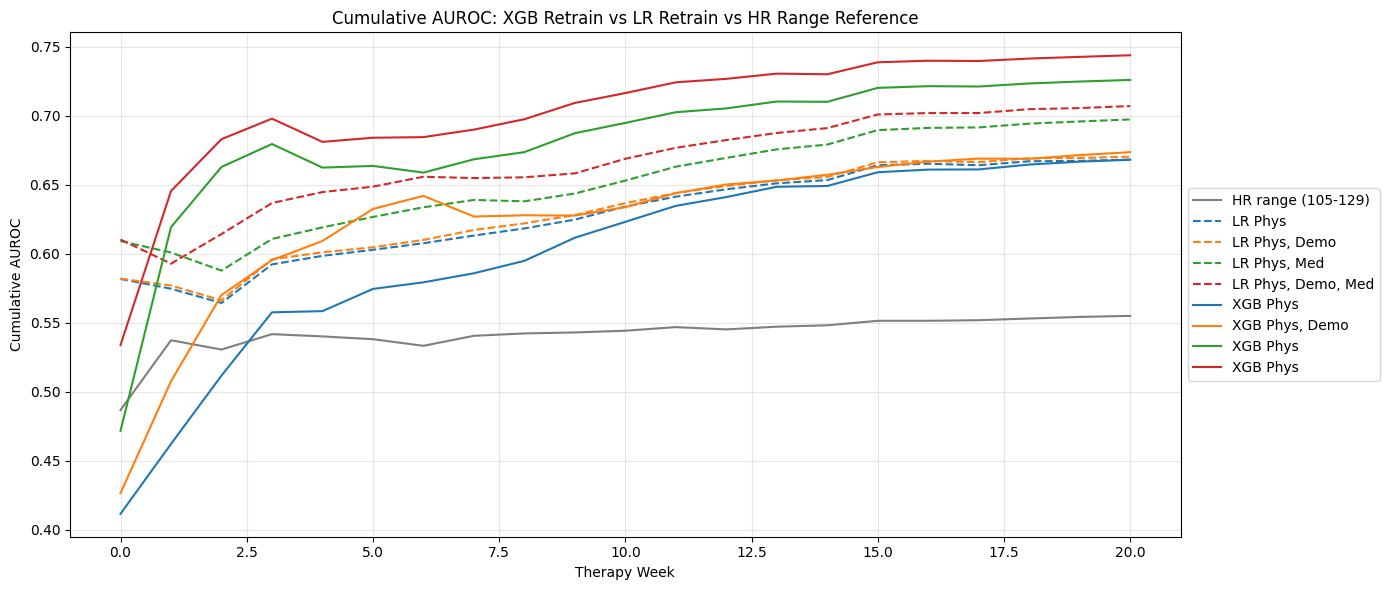

In [24]:
# Plot XGB retrain vs LR retrain models with HR range as reference

plt.figure(figsize=(14, 6))


# HR range reference
def weekly_cum_metric(results, metric_fn):
    results = [r for r in results if r[0] <= weeks[-1]]
    metrics = []
    all_y_pred_proba = np.empty((0, 2))
    all_y_pred = np.array([])
    all_y_true = np.array([])
    for week, y_pred_proba, y_pred, y_true, _ in results:
        all_y_pred_proba = np.concatenate([all_y_pred_proba, y_pred_proba])
        all_y_pred = np.concatenate([all_y_pred, y_pred])
        all_y_true = np.concatenate([all_y_true, y_true])
        metric = roc_auc_score(all_y_true, all_y_pred_proba[:, 1])
        metrics.append((week, metric))
    return metrics


hr_cum_auc = weekly_cum_metric(hr_model_results, roc_auc_score)
plt.plot(*zip(*hr_cum_auc), label="HR range (105-129)", color="tab:grey")

# LR retrain
lr_auc = weekly_cum_metric(retrain_dyad_results["lrl2"]["watch"], roc_auc_score)
plt.plot(*zip(*lr_auc), label="LR Phys", color="tab:blue", linestyle="--")
lr_auc = weekly_cum_metric(
    retrain_dyad_results["lrl2"]["watch_demographic"], roc_auc_score
)
plt.plot(*zip(*lr_auc), label="LR Phys, Demo", color="tab:orange", linestyle="--")
lr_auc = weekly_cum_metric(retrain_dyad_results["lrl2"]["watch_medical"], roc_auc_score)
plt.plot(*zip(*lr_auc), label="LR Phys, Med", color="tab:green", linestyle="--")
lr_auc = weekly_cum_metric(
    retrain_dyad_results["lrl2"]["watch_demographic_medical"], roc_auc_score
)
plt.plot(*zip(*lr_auc), label="LR Phys, Demo, Med", color="tab:red", linestyle="--")


# XGB retrain
lr_auc = weekly_cum_metric(retrain_dyad_results["xgboost"]["watch"], roc_auc_score)
plt.plot(*zip(*lr_auc), label="XGB Phys", color="tab:blue")
lr_auc = weekly_cum_metric(
    retrain_dyad_results["xgboost"]["watch_demographic"], roc_auc_score
)
plt.plot(*zip(*lr_auc), label="XGB Phys, Demo", color="tab:orange")
lr_auc = weekly_cum_metric(
    retrain_dyad_results["xgboost"]["watch_medical"], roc_auc_score
)
plt.plot(*zip(*lr_auc), label="XGB Phys", color="tab:green")
lr_auc = weekly_cum_metric(
    retrain_dyad_results["xgboost"]["watch_demographic_medical"], roc_auc_score
)
plt.plot(*zip(*lr_auc), label="XGB Phys", color="tab:red")

plt.xlabel("Therapy Week")
plt.ylabel("Cumulative AUROC")
plt.title("Cumulative AUROC: XGB Retrain vs LR Retrain vs HR Range Reference")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()